# 4 weeks

#### Imports and config

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
from model_functions import *

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', 50)
np.set_printoptions(threshold=1000)#np.inf

#### Load file

In [5]:
with open("./4week_transformed_droppedErrors_filled.pkl", "rb") as pickleFile:
    ds = pickle.load(pickleFile)
ds.index = pd.to_datetime(ds.index)

#### Prediction Column

In [6]:
prediction_column = 'cpuusage_ps' #cpuusage_ps,host_cpu_usage_pct 
ds["cpu"] = pd.to_numeric(ds[prediction_column], errors='coerce')
ds = ds.drop(prediction_column,1)

In [7]:
ds = get_time_features(ds)

In [8]:
ds.head(1)

,transactions_ps,opt_sga_size,sga_total,fixed_sga,java_pool,shared_pool,buffer_cache,pga_total,other_sga_memory,log_buffer,large_pool,streams_pool,total_pga_allocated,hardParseBindMismElTimePs,javaExecutionElapsedTimePs,plsqlEexecutionElapsedTimePs,connManageCallElapsedTimePs,failedParseElapsedTimePs,dbTimePs,hardParseSharCritElTimePs,plsqlCompilationElapsedTimePs,bgCpuTimePs,sqlExecuteElapsedTimePs,parseTimeElapsedPs,failedParseSharMemElTimePs,...,pxdwngrdserial_ps,pgacachehit_pct,pxdwngrdserial_pt,pxdwngrd50_ps,libcache_hit_pct,inmem_sort_pct,dumpAvail,dumpTotal,dumpUsedPercent,dumpUsed,scn_intrinsic_growth_rate,max_tot_cpu_usage_ps,avg_tot_cpu_usage_ps,cpu,weekday,hour,minute,week_sin,week_cos,hour_sin,hour_cos,minute_sin,minute_cos,is_weekend,is_6am
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-25 08:45:00,1.586,10240,20479.998,21.732,320,4928,14336,1144.103,384,42.266,320,128,1147.1,0,0,.394,0,0,.534,.001,0,.063,.531,.009,0,...,0,100,0,0,42.426,100,111168864.0,167731204.0,34.0,56562340.0,7.453,62.7392110050968,8.88793132698182,11.592,3,08,45,0.433884,-0.900969,0.866025,-0.5,-1.0,-1.836970e-16,0,1


### Feature Selection

In [9]:
x = extract_time_features(ds, feature_map='all') #optional feature_map: 'orig', 'all', 'cyc' (orig, cyc - only datetime Features)
y = ds.cpu.values

### Train Test Split Shifted

shift = testsize, necessary to predict the "future"

In [10]:
shi = 80 #96 would be 1day shift / shift for best performance 5h rhythm -> 20 * x

In [11]:
X_train = x[:(-2*shi)]; X_test = x[(-2*shi):-shi]

In [12]:
y_train = y[shi:-shi]; y_test = y[-shi:]

In [13]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2629, 191) (80, 191)
(2629,) (80,)


## Scaling

In [14]:
X_train, X_test = scale_train_test(X_train,X_test, scaler="standard")# minmax
#y_train, y_test = scale_train_test(y_train.values.reshape(-1,1),y_test.values.reshape(-1,1)) #optional scaling of y

## Measure Performance

In [15]:
ml_mods = ['knn','lr','dt','mlp', 'gp'] #Choose Models : 'knn','lr','dt','mlp', 'gp'
measure_performance(X_train, X_test, y_train, y_test, ml_mods)

,MSE,RMSE,MAE,MAPE,R2
knn,0.956965,0.978246,0.638371,46.834280,0.826324
lr,11.252901,3.354534,1.057467,218.597699,-1.042249
dt,0.126118,0.355131,0.164825,23.901844,0.977111
mlp,24.227358,4.922129,1.400510,899.360513,-3.396938
gp,0.350938,0.592400,0.459041,61.162329,0.936309


## k-nn (nearest neighbor)

Euklidischer Abstand Funktion:
$$dist(x,y)=\sqrt{\sum_{i=1}^k (x_i - y_i)^2}$$

k wird bestimmt, welches die Anzahl der vergleichenen Nachbarn wählt
es werden k Einträge bestimmt, welche den geringsten Abstand zu vergleichenden Wert haben
davon wird der Mittelwert gebildet

$$\hat{f}(\overrightarrow{x})=\frac{1}{k}\sum_{\overrightarrow{x_i}\in N_k(\overrightarrow{x})} y_i $$

Die Nachbarschaft $N_k(\overrightarrow{x})$ wird durch das Abstandsmaß bestimmt

K rausfinden

In [16]:
nei = round(math.sqrt(len(X_train)))
nei

51

In [17]:
model_knn = KNeighborsRegressor(n_neighbors=nei, metric='euclidean', weights='uniform', algorithm='brute')
model_knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=51, p=2,
                    weights='uniform')

In [18]:
pred_train = model_knn.predict(X_train)
pred_test = model_knn.predict(X_test)

In [19]:
len(y_test)

80

In [20]:
get_score(y_test,pred_test)

MSE : 0.9032398651336024
RMSE: 0.9503893229269794
MAE : 0.6216914215686274
MAPE: 46.58127182944483
R2  : 0.836074167068333


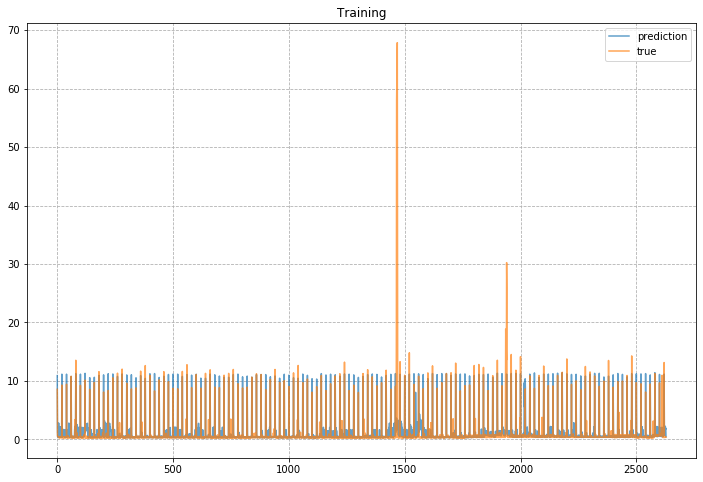

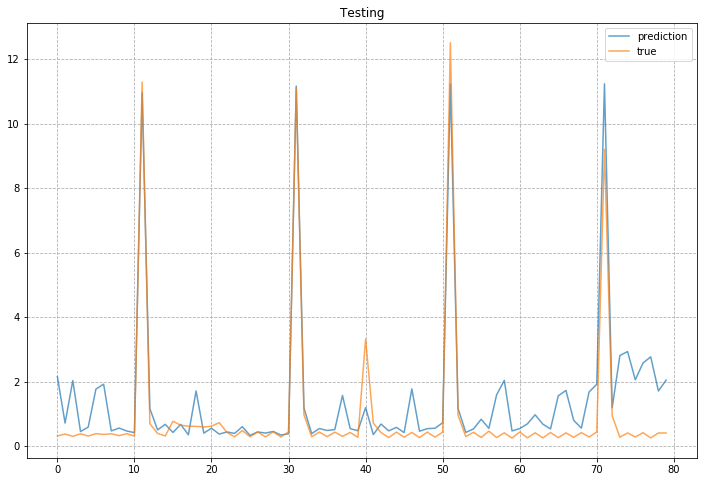

In [21]:
plot_train_test(pred_train,y_train, pred_test, y_test)

## GP gauss process

In [22]:
kernel = (ConstantKernel() * DotProduct() 
          + ConstantKernel() * WhiteKernel() 
          + ConstantKernel() * RBF())

model_gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
model_gpr.score(X_train, y_train)

0.9214563721575428

In [23]:
pred_train = model_gpr.predict(X_train)
pred_test = model_gpr.predict(X_test)

In [24]:
get_score(y_test,pred_test)

MSE : 0.3509380700663184
RMSE: 0.592400261703452
MAE : 0.4590414407732785
MAPE: 61.16232947840506
R2  : 0.9363094813861612


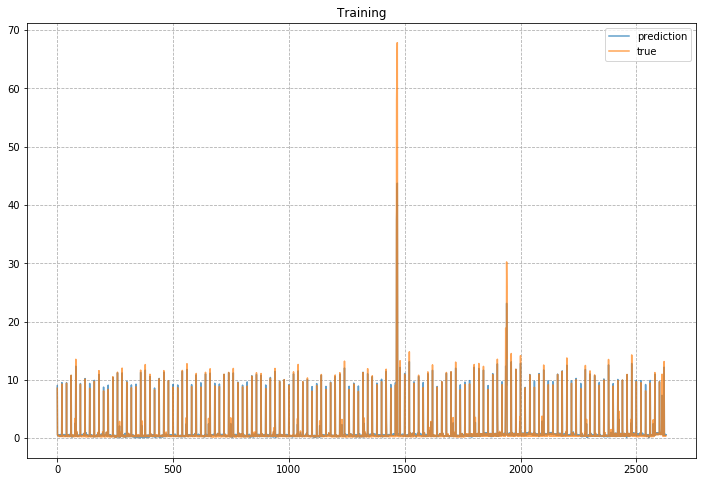

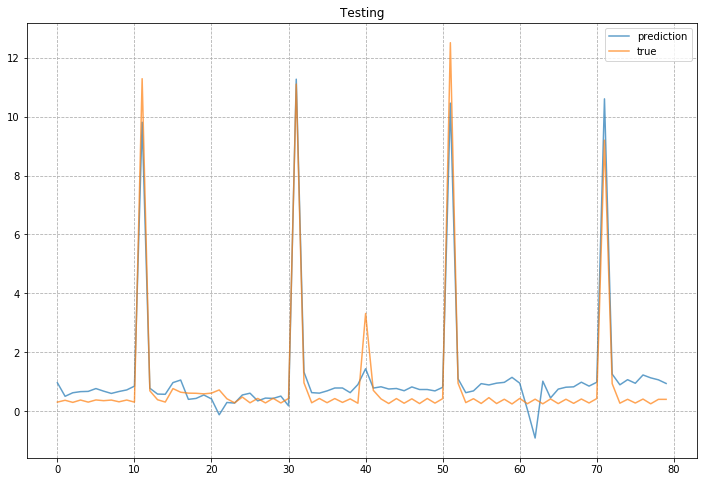

In [25]:
plot_train_test(pred_train,y_train, pred_test, y_test)

##  Linear Regression

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_nX_n + \epsilon$$
mit 
$$\epsilon \sim \mathcal{N}(0, \sigma^2)$$

$Y$ ist die abhängige Variable (vorherzusagender Wert)

$\beta_0$ ist der Y-Achsenabschnitt (Konstant)

$\beta_1$ ist die Steigung (Regressions Koeffizient)

$X_1$ ist die unabhängige Inputvariable

$\epsilon$ ist die zufällige Fehler Komponente 

In [26]:
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
pred_train = model_lr.predict(X_train)
pred_test = model_lr.predict(X_test)

In [28]:
get_score(y_test,pred_test)

MSE : 11.252900668283338
RMSE: 3.3545343444781333
MAE : 1.0574670345310364
MAPE: 218.5976988499808
R2  : -1.0422494468540853


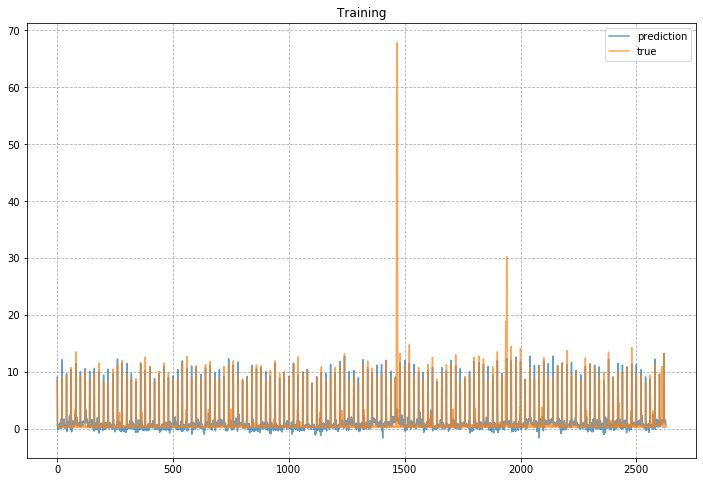

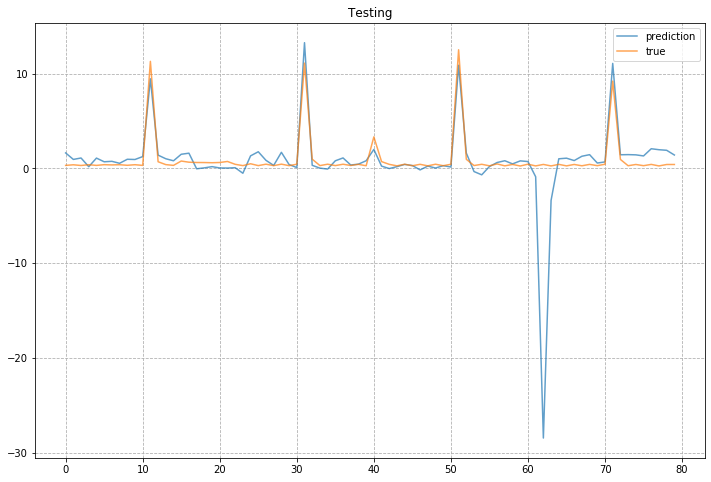

In [29]:
plot_train_test(pred_train,y_train, pred_test, y_test)

### DTs (Decision Trees) 

$(x,Y)=(x_1,x_2,x_3,\dots, x_k,Y)$

$Y$ ist die abhängige Variable, $x$ der Vektor und $x_1,x_2$ etc. sind die Features

$$\sum_{\hat{x},\hat{y}\in D}(f(\hat{x})-\hat{y})^2$$

dataset $D=\{(\hat{x},\hat{y}\}$



$y =f(x)=\sum_{m=1}^M c_m I \{ x\in R_m \}$

$R_m$ ist subset

$c_m$ ist konstant

$I\{x\in R_m \}$ ist Identifizierungsfunktion, welche 1 zurückgibt, wenn $x$ im subset $R_m$ liegt, 0 andernfalls

wenn eine Instanz in $R_l$ (leaf node) fällt ist der vorhergesagte Wert $y=c_l$ und $c_l$ der average aller Trainingsinstanzen in $R_l$

node $m$ ist dargestellt durch $Q$ und sei die Teilfunktion split $\theta = (j,t_m)$ bestehend aus dem feature $j$ und der Schwelle $t_m$, welche die Daten in die subsets $Q_{left}(\theta)$ und $Q_{right}(\theta)$ teilt : 

$$Q_{left}(\theta)=(x,y)\mid x_j <= t_m$$
$$Q_{right}(\theta)=Q\backslash Q_{left}(\theta)$$

In [30]:
model_dt = DecisionTreeRegressor(random_state=0)
#criterion= mse;friedman_mse,mae 
#splitter=best;random
model_dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [31]:
pred_train = model_dt.predict(X_train)
pred_test = model_dt.predict(X_test)

In [32]:
model_dt.score(X_train, y_train)

1.0

In [33]:
get_score(y_test,pred_test)

MSE : 0.1261181000000001
RMSE: 0.3551311025522829
MAE : 0.16482500000000005
MAPE: 23.90184447449286
R2  : 0.9771112686803286


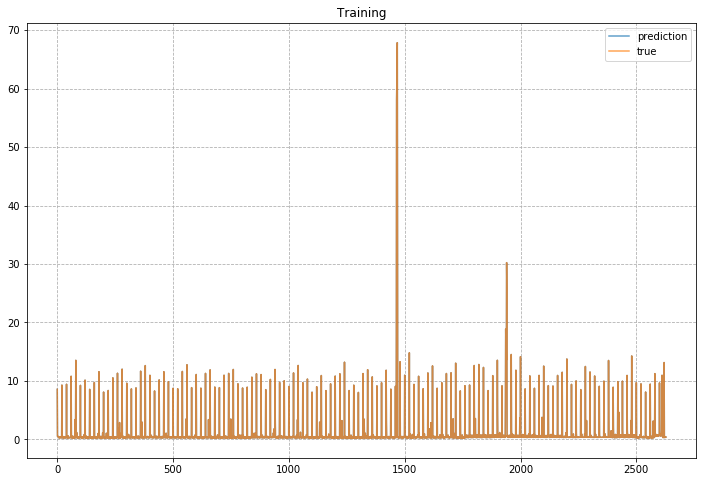

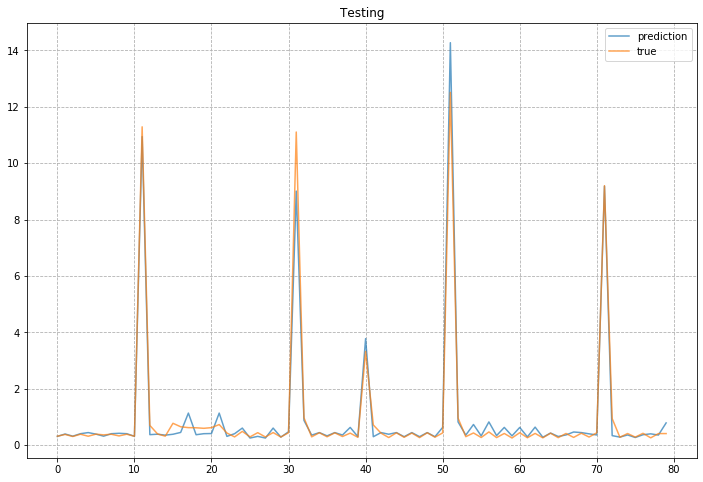

In [34]:
plot_train_test(pred_train,y_train, pred_test, y_test)

## MLPRegressor

In [35]:
model_nn = MLPRegressor(hidden_layer_sizes=[50, 50], activation='tanh')
model_nn.fit(X_train, y_train)

/Users/jan/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[50, 50], learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [36]:
pred_train = model_nn.predict(X_train)
pred_test = model_nn.predict(X_test)

In [37]:
get_score(y_test,pred_test)

MSE : 19.209477192069905
RMSE: 4.382861758265928
MAE : 2.444338613221465
MAPE: 113.42591410759977
R2  : -2.486260594162488


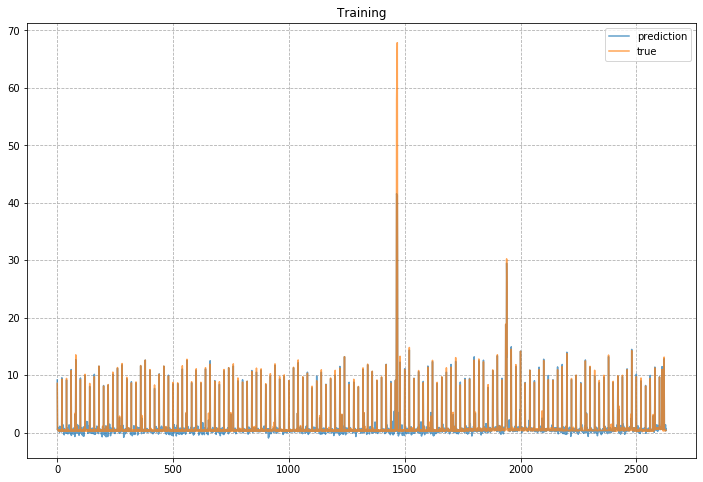

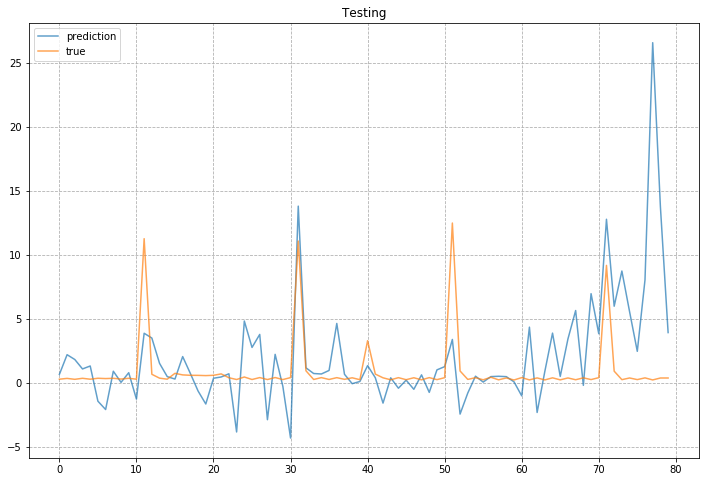

In [38]:
plot_train_test(pred_train,y_train, pred_test, y_test)

## Summary

While using all Features:
Decision Trees, Gaussian Process and KNN perform best, but it is all case sensitive and depending on the shift, if the shift is not a multiple of 20, which is the period of the peaks, results vary.
GP also takes way longer to compute. 
Linear Regression performs weaker, but has an extreme negative outlier, probably because of the 2 outliers in the training set. 
If the data always looks similiar and there is an constant periodic behaviour, it would also be possible to catch that period beforehand and adjust the shift, so the models would perform well. 